In [1]:
from datasets import *
from model import *
from config import *
from visualize import visualize_pointcloud
from train import *

[Taichi] version 1.7.0, llvm 15.0.7, commit 7b58b0ff, osx, python 3.9.13


[I 10/30/23 12:35:47.166 2110206] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [ ]:

def visualize_pointcloud_components(pts):
    namo_colors = [
    '#1f77b4',  # muted blue
    '#005073',  # safety orange
    '#96aab3',  # cooked asparagus green
    '#2e3e45',  # brick red
    '#08455e',  # muted purple
    '#575959',  # chestnut brown
    '#38677a',  # raspberry yogurt pink
    '#187b96',  # middle gray
    '#31393b',  # curry yellow-green
    '#1cd1ed'   # blue-teal
    ]
    all_pts = pts.reshape([-1,3])
    N = pts.shape[0]
    rang = 0.7
    s = 3.0
    fig = plt.figure("visualize",figsize=(s * N//2,s * 2), frameon = True)
    full_fig = plt.figure("full_viz", figsize = (s,s), frameon = False)
    full_rows = 2
    full_cols = N // 2 
    full_ax = full_fig.add_subplot(1,1,1,projection='3d')
    full_ax.set_axis_off()
    full_ax.set_zlim(-rang,rang);full_ax.set_xlim(-rang,rang);full_ax.set_ylim(-rang,rang)
    for i in range(N):
        row = i // full_cols
 
        ax = fig.add_subplot(2, full_cols , 1 + i  , projection='3d')
        ax.set_zlim(-rang,rang);ax.set_xlim(-rang,rang);ax.set_ylim(-rang,rang)
        # make the panes transparent
        for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
            axis.set_ticklabels([])
            axis._axinfo['axisline']['linewidth'] = 1
            axis._axinfo['axisline']['color'] = (0, 0, 0)
            #axis._axinfo['grid']['linewidth'] = 0.5
            #axis._axinfo['grid']['linestyle'] = "-"
            axis._axinfo["grid"]['color'] =  (1,1,1,0)
            axis._axinfo['tick']['inward_factor'] = 0.0
            axis._axinfo['tick']['outward_factor'] = 0.0
            axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.set_axis_off()
        ax.view_init(elev = -80, azim = 90)
        for j in range(N):
            coords = pts[j]
            colors = namo_colors[j]
            alpha = 1.0 if i == j else 0.01
            ax.scatter(coords[:,0],coords[:,1],coords[:,2], c = colors, alpha = alpha)
        coords = pts[i]
        colors = namo_colors[i]
        full_ax.scatter(coords[:,0],coords[:,1],coords[:,2], c = colors)
        ax.view_init(elev = -80, azim = 90)
    fig.savefig("outputs/pc_components.png")
    full_fig.savefig("outputs/pc_full_components.png")

In [ ]:
argparser = argparse.ArgumentParser()
# [general config of the training]
argparser.add_argument("--phase",                   default = "0")
argparser.add_argument("--device",                  default = config.device)
argparser.add_argument("--name",                    default = "KFT")
argparser.add_argument("--epoch",                   default = 400 * 3)
argparser.add_argument("--optimizer",               default = "Adam")
argparser.add_argument("--lr",                      default = 1e-3)
argparser.add_argument("--batch_size",              default = 1)
argparser.add_argument("--dataset",                 default = "StructureNet")
argparser.add_argument("--category",                default = ["chair"])
argparser.add_argument("--freeze_perception",       default = False)
argparser.add_argument("--concept_type",            default = False)

# [perception and language grounding training]
argparser.add_argument("--perception",              default = "csqnet")
argparser.add_argument("--training_mode",           default = "joint")
argparser.add_argument("--alpha",                   default = 1.00)
argparser.add_argument("--beta",                    default = 1.0)

# [additional training details]
argparser.add_argument("--warmup",                  default = True)
argparser.add_argument("--warmup_steps",            default = 300)
argparser.add_argument("--decay",                   default = False)
argparser.add_argument("--decay_steps",             default = 20000)
argparser.add_argument("--decay_rate",              default = 0.99)
argparser.add_argument("--shuffle",                 default = True)

# [curriculum training details]
argparser.add_argument("--effective_level",         default = 1)

# [checkpoint location and savings]
argparser.add_argument("--checkpoint_dir",          default = False)
argparser.add_argument("--checkpoint_itrs",         default = 10,       type=int)
argparser.add_argument("--pretrain_perception",     default = False)

args = argparser.parse_args(args = [])

if __name__ == "__main__":
    args.checkpoint_dir = "checkpoints/KFT_StructureNet_0.ckpt"

model = Halearner(config)

/Users/melkor/Documents/GitHub/Hierarchical-Learner/HierarchyLearner/knowledge/structure_chair_concept_vocab.txt


start the demo
StructureGrouding Net with  ['chair']


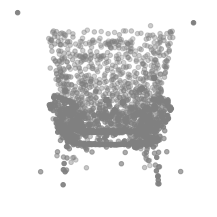

In [ ]:

print("start the demo")

args.dataset = "StructureNet"

B = 1
if args.dataset == "StructureNet":
    dataset = StructureGroundingDataset(config, category=args.category, split = "train")
if args.dataset == "Multistruct":dataset = multistructnet4096("train","airplane", False)

#dataset = multistructnet4096("train","airplane", False)
config.num_pts = 4096

dataloader = DataLoader(dataset, batch_size = B, shuffle = True)

# [Get A Sample Data]
itr = 0
for sample in dataloader:
    sample, gt = sample
    itr += 1
    if itr == 2:
        break

model = torch.load("tmp.ckpt")

model.perception.split_components = True
outputs = model.perception(sample)

components = outputs["components"]

coords = outputs["recon_pc"].detach()
n = coords.shape[0]
coords_colors = torch.ones([n,3]) * 0.5

in_coords = sample["point_cloud"][0]
n = in_coords.shape[0]
in_colors = torch.ones([n,3]) * 0.5
input_pcs = [(coords,coords_colors),[in_coords, in_colors]]

visualize_pointcloud(input_pcs)

This is the comparison between the reconstruct point cloud and input point cloud.

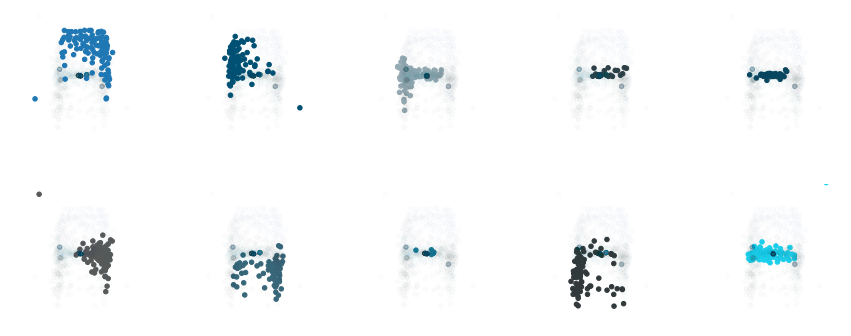

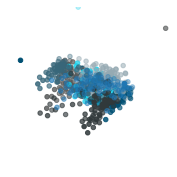

In [ ]:
visualize_pointcloud_components(components[0].detach())

This the primitive segmentation of parts of the point cloud.

In [ ]:
print(outputs["features"].shape)
base_features = outputs["features"]
object_map = nn.Linear(131,100)
base_features = object_map(base_features)
print(base_features.shape)

torch.Size([1, 10, 131])
torch.Size([1, 10, 100])


In [ ]:
scene_struct = model.build_scene(base_features)

In [ ]:
for s in reversed(scene_struct["scores"]):print(s[0])
for f in reversed(scene_struct["features"]):print(f[0].shape)
print("Match Matrix:")
for c in reversed(scene_struct["connections"]):print(c[0].shape)

tensor([0.4025], grad_fn=<SelectBackward0>)
tensor([0.3386, 0.4025, 0.3310, 0.3306], grad_fn=<SelectBackward0>)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
torch.Size([1, 100])
torch.Size([4, 100])
torch.Size([10, 100])
Match Matrix:
torch.Size([1, 4])
torch.Size([4, 10])


Question Ansering Based on Structured Scene.

In [ ]:
def load_scene(scene, k): 
    scores = scene["scores"]; features = scene["features"]; connections = scene["connections"]
    return [score[k] for score in scores], [feature[k] for feature in features], \
        [connection[k] for connection in connections[1:]]

In [ ]:
scores,features,connections = load_scene(scene_struct, 0)

kwargs = {"features":features,
        "end":scores,
        "connections":connections}


qa_programs = [
    "exist(filter(scene(),leg))",
    ]
answers = [
    "yes"
]

language_loss = 0.0
model.executor.effective_level = 1
for i,q in enumerate(qa_programs):
        answer = answers[i]

        q = model.executor.parse(q)

                        
        o = model.executor(q, **kwargs)
        
        print(q,answer)
        print(o["end"].sigmoid().detach().numpy())

        if answer in ["True","False"]:answer = {"True":"yes,","False":"no"}[answer]
        if answer in ["1","2","3","4","5"]:answer = num2word(int(answer))
                        
        if answer in numbers:
            int_num = torch.tensor(numbers.index(answer)).float().to(args.device)
            language_loss += F.mse_loss(int_num ,o["end"])
                            
        if answer in yes_or_no:
            if answer == "yes":
                language_loss -= torch.log(torch.sigmoid(o["end"]))
            else:
                language_loss -= torch.log(1 - torch.sigmoid(o["end"]))

Exist(Filter(Scene(), leg)) yes
0.060159557


In [ ]:
# /Users/melkor/miniforge3/envs/Melkor/bin/python ./main.py --log_dir=plane_dim2 --indim=2 --scheduler=5
args.epoch = 320
model.perception.split_components = False
model = train(model, config, args, num_sample = 100)

start the experiment: KFT query:[False]
experiment config: 
epoch: 320 
batch: 1 samples 
lr: 0.001

alpha:1.0 beta:1.0
Epoch: 320, Itrs: 31999 Loss: 2.5122060775756836 Percept:2.5122060775756836 Language:0.0, Time: 2:11:51.934955

Experiment KFT : Training Completed.


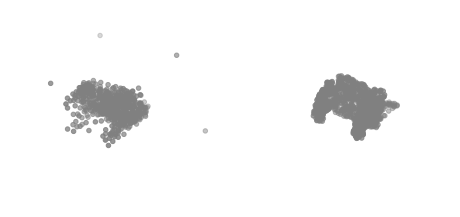

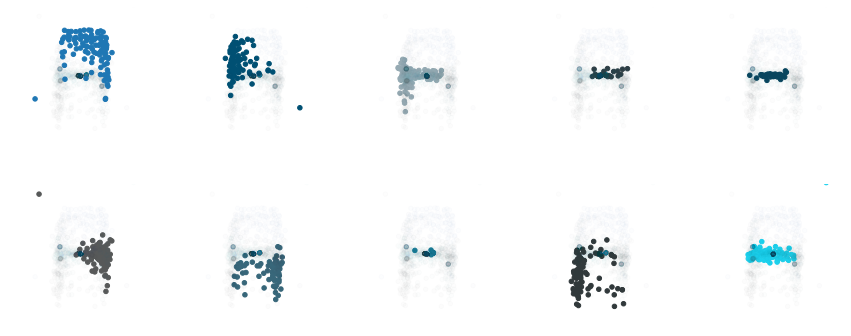

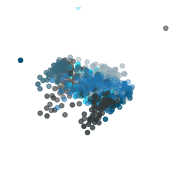

In [ ]:
# Contents After the Training
model.perception.split_components = True
outputs = model.perception(sample)

components = outputs["components"]

coords = outputs["recon_pc"].detach()
n = coords.shape[0]
coords_colors = torch.ones([n,3]) * 0.5

in_coords = sample["point_cloud"][0]
n = in_coords.shape[0]
in_colors = torch.ones([n,3]) * 0.5
input_pcs = [(coords,coords_colors),[in_coords, in_colors]]

visualize_pointcloud(input_pcs)
#visualize_pointcloud_components(components[0].detach())

scene_struct = model.build_scene(base_features)

#for s in reversed(scene_struct["scores"]):print(s[0])
#for f in reversed(scene_struct["features"]):print(f[0].shape)
#print("Match Matrix:")
#for c in reversed(scene_struct["connections"]):print(c[0].shape)
plt.show()
visualize_pointcloud_components(components[0].detach())

In [ ]:
args.epoch = 3200
args.alpha = 1.0
args.beta = 1.0
model.perception.split_components = False
args.freeze_perception = False

unfreeze_parameters(model.perception)
model = train(model, config, args, num_sample = 100, phase = "1")

start the experiment: KFT query:[True]
experiment config: 
epoch: 3200 
batch: 1 samples 
lr: 0.001

StructureGrouding Net with  chair
alpha:1.0 beta:1.0
Epoch: 454, Itrs: 45309 Loss: 1.9950639009475708 Percept:1.8032963275909424 Language:0.191767618060112, Time: 20:40:57.872521790

KeyboardInterrupt: 

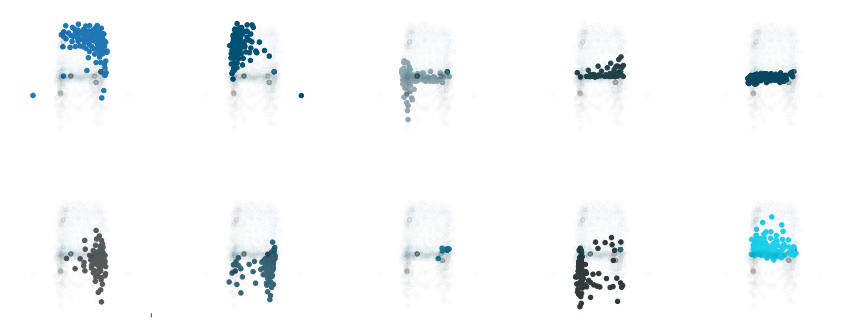

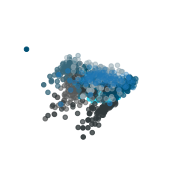

StructureGrouding Net with  ['chair']


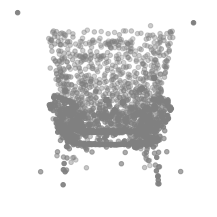

[tensor([[0.6628, 0.5494, 0.7475, 0.6451]], grad_fn=<SelectBackward0>)]
0.96015257
Exist(Filter(Scene(), leg)) yes
0.0005957476
Exist(Filter(Scene(), chair)) no
tensor([-6.0317, -4.6306, -1.2565, -2.0611, -2.1779, -5.7134, -2.3566, -5.7322,
         3.1820, -2.6879], grad_fn=<CatBackward0>)
tensor([-16.1181, -16.1181, -16.1181, -16.1181], grad_fn=<CatBackward0>)
tensor([-16.1181], grad_fn=<CatBackward0>)


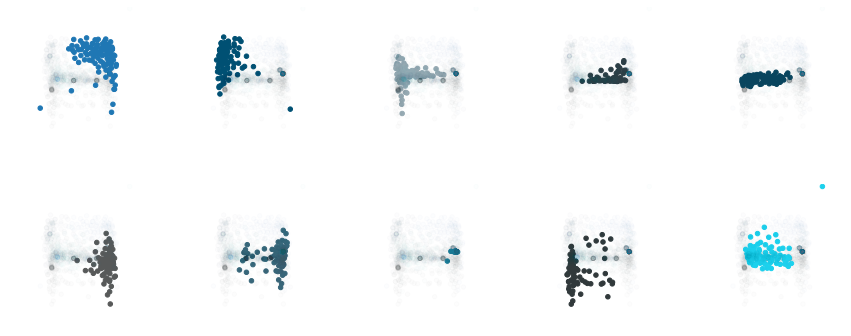

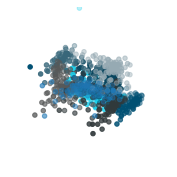

In [ ]:
visualize_pointcloud_components(components[0].detach())
plt.show()

train_dataset = StructureGroundingDataset(config, category = args.category, split = "train", phase = "1")

train_dataset = torch.utils.data.Subset(train_dataset, list(range(100)))
dataloader = DataLoader(train_dataset, batch_size = int(args.batch_size), shuffle = args.shuffle)

for sample in dataloader:
    sample, gt = sample
    break;

model.perception.split_components = True
outputs = model.perception(sample)
components = outputs["components"]

base_features = outputs["features"]
base_features = model.feature2concept(base_features)

visualize_pointcloud(input_pcs)
#visualize_pointcloud_components(components[0].detach())


plt.show()
visualize_pointcloud_components(components[0].detach())
print(connections)


scene_struct = model.build_scene(base_features)

scores,features,connections = load_scene(scene_struct, 0)

kwargs = {"features":features,
        "end":scores,
        "connections":connections}


qa_programs = [
    "exist(filter(scene(),leg))",
    "exist(filter(scene(),chair))",
    "filter(scene(),leg)",
    ]
answers = [
    "yes","no","na","na"
]

language_loss = 0.0
model.executor.effective_level = 1
for i,q in enumerate(qa_programs):
        answer = answers[i]

        q = model.executor.parse(q)

                        
        o = model.executor(q, **kwargs)
        
        
        if isinstance(o["end"],list):
            for item in o["end"]:print(item)
        else:
            print(o["end"].sigmoid().detach().numpy())
            print(q,answer)

[('exist(filter(scene(),back_frame))',), ('exist(filter(scene(),rocker))',), ('exist(filter(scene(),bar_stretcher))',), ('exist(filter(scene(),regular_leg_base))',), ('exist(filter(scene(),foot))',), ('exist(filter(scene(),back_surface))',), ('exist(filter(scene(),seat_frame_bar))',), ('exist(filter(scene(),back_holistic_frame))',), ('exist(filter(scene(),star_leg_base))',), ('exist(filter(scene(),other))',), ('exist(filter(scene(),back_holistic_frame))',), ('exist(filter(scene(),back_surface_vertical_bar))',)]
[('no',), ('no',), ('yes',), ('no',), ('no',), ('no',), ('yes',), ('no',), ('no',), ('no',), ('no',), ('yes',)]
tensor([-4.4450, -6.0980, -4.5461, -1.9362, -2.0114, -1.7426, -5.8343, -1.7906,
         3.4503, -1.5808], grad_fn=<CatBackward0>)


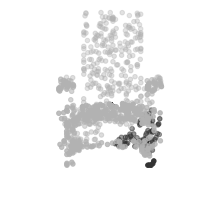

In [ ]:
def generate_segmentation(model,sample, target_concepts = ["leg"]):
    segmentations = []
    loader = DataLoader(dataset, batch_size = 1)
    if 1:
        model.perception.split_components = True
        outputs = model.perception(sample)
        model.executor.effective_level = 1
        components = outputs["components"]
        attn = outputs["attention"]

        base_features = outputs["features"]
        base_features = model.feature2concept(base_features)

        scene_struct = model.build_scene(base_features)

        scores,features,connections = load_scene(scene_struct, 0)

        kwargs = {"features":features,
                "end":scores,
                "connections":connections}
        
        q = "filter(scene(),{})".format(target_concepts[0])
        q = model.executor.parse(q)
    
        o = model.executor(q, **kwargs)

        soft_mask = o["end"][0]
        print(soft_mask)
        partial_pc = []
        rest = []
        
        pc = sample["point_cloud"]
        att_mask = torch.zeros([pc.shape[0]])
        rest_attn = torch.zeros(pc.shape[1])
        for i,val in enumerate(soft_mask):
            if val > 0.0:
                att_mask = torch.max(att_mask, (attn[0,i,:] + 0.5).int())
                partial_pc.append(components[0][i])
            else:
                #att_mask = torch.max(att_mask, (attn[0,i,:] + 0.5).int())
                rest_attn = torch.max(rest_attn, (attn[0,i,:] + 0.5).int())
                rest.append(components[0][i])

        #partial_pc = torch.cat(partial_pc, dim = 0)
        #rest = torch.cat(rest, dim = 0)

        partial = pc * att_mask.unsqueeze(-1)
        partial = partial.detach()[0]

        rest_partial = pc * rest_attn.unsqueeze(-1)
        rest_partial = rest_partial.detach()[0]
        
        #visualize_pointcloud([
        #    [partial_pc.detach(),0.0 * torch.ones_like(partial_pc)],
        #    [rest.detach(), .7 * torch.ones_like(rest)]
        #    ])

        visualize_pointcloud([
            [partial, 0.2 * torch.ones_like(partial)],
            [rest_partial, 0.7 * torch.ones_like(rest_partial)]
            ])

    return segmentations

for sample in dataloader:
    sample, gt = sample
    break;

print(sample["programs"])
print(sample["answers"])

seg = generate_segmentation(model, sample, ["leg","back_single_surface","leg","runner"])

In [ ]:
model = torch.load("tmp.ckpt")
#torch.save(model,"tmp.ckpt")

In [ ]:

def visualize_pointcloud(input_pcs,name="pc"):
    rang = .6; N = len(input_pcs)
    num_rows = 3
    fig = plt.figure("visualize",figsize=plt.figaspect(1/N), frameon = True)
    ax = fig.add_subplot(1, N , 1 + 0, projection='3d')
    for i in range(N):
        #
        ax.set_zlim(-rang,rang);ax.set_xlim(-rang,rang);ax.set_ylim(-rang,rang)
        # make the panes transparent
        for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
            axis.set_ticklabels([])
            axis._axinfo['axisline']['linewidth'] = 1
            axis._axinfo['axisline']['color'] = (0, 0, 0)
            axis._axinfo['grid']['linewidth'] = 0.5
            axis._axinfo['grid']['linestyle'] = "-"
            axis._axinfo["grid"]['color'] =  (1,1,1,0)
            axis._axinfo['tick']['inward_factor'] = 0.0
            axis._axinfo['tick']['outward_factor'] = 0.0
            axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.set_axis_off()
        ax.view_init(elev = 100, azim = -90)
        coords = input_pcs[i][0]
        colors = input_pcs[i][1]
        ax.scatter(coords[:,0],coords[:,1],coords[:,2], c = colors)
    plt.savefig("outputs/{}.png".format(name))